In [1]:
import tqdm
import pandas as pd


In [2]:
import os
os.listdir('./input'
)

['test.csv', 'train.csv']

In [3]:
train_path = './input/train.csv' 
test_path = './input/test.csv'
train_df = pd.read_csv(train_path,parse_dates=['activation_date'])
test_df = pd.read_csv(test_path,parse_dates = ['activation_date'])

In [4]:
train_df = train_df.sort_values(by='activation_date')

In [5]:
# 在这里就划分 training 和 validaiton 的index
# 将数据分成七份
num_train = train_df.shape[0]
import math
each_length = math.floor(num_train/7)
train_index = []
valid_index=  []
for i in range(5):
    train_ind = range(i*each_length,(i+2)*each_length)
    valid_ind = range((i+2)*each_length,(i+3)*each_length)
    train_index.append(train_ind)
    valid_index.append(valid_ind)



In [6]:
# 拼接 train_df 和 test_df
all_df = pd.concat([train_df,test_df],axis=0)
num_train = train_df.shape[0]
import gc
#del train_df,test_df

In [7]:
gc.collect()
all_df.shape

(2011862, 18)

In [8]:
# 先处理缺失值,全都用null填充
for item in all_df.columns:
    if all_df[item].isnull().sum()!=0 and item!='price':
        all_df[item].fillna('null',inplace=True)


(array([6.57000e+03, 5.16800e+03, 4.67000e+02, 1.27000e+03, 4.21700e+03,
        2.40300e+03, 6.86100e+03, 1.87110e+04, 9.77000e+03, 8.60530e+04,
        6.90010e+04, 2.18966e+05, 2.31065e+05, 2.46895e+05, 1.49618e+05,
        1.79922e+05, 1.23254e+05, 8.51650e+04, 8.12220e+04, 5.99450e+04,
        3.18900e+04, 2.28130e+04, 1.96950e+04, 2.11500e+04, 2.49820e+04,
        2.95920e+04, 2.83020e+04, 2.82060e+04, 4.01370e+04, 3.56290e+04,
        1.64130e+04, 5.42500e+03, 2.65000e+03, 1.16800e+03, 6.51000e+02,
        3.28000e+02, 1.55000e+02, 8.60000e+01, 5.60000e+01, 2.80000e+01,
        7.00000e+00, 5.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.        ,  0.50198071,  1.00396142,  1.50594214,  2.00792285,
         2.50990356,  3.01188427,  3.51386498,  4.01584569,  4.51782641,
         5.01980712,  5.52178783,  6.02376854,  6.52574925,  7.02772996,
         7.52971068,  8.03169139,  8.5336721 ,  9

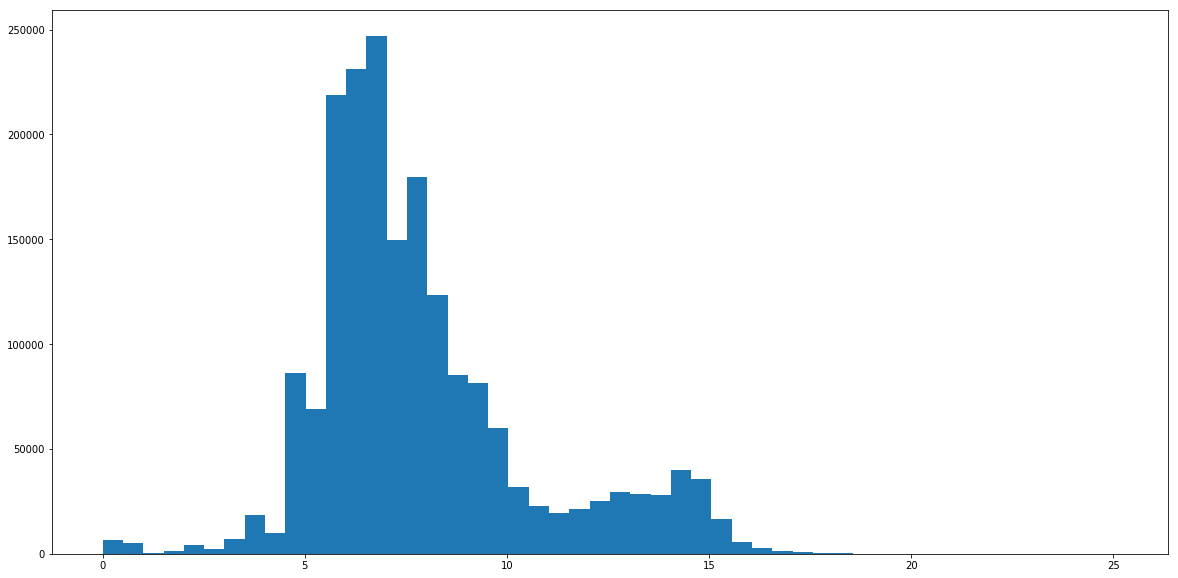

In [9]:
# 填充数值型数据的缺失
# 均值 or 中位数 取决于price的分布情况

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
price_value = all_df['price'][all_df['price'].notnull()].values
import math
price_value_logged = [math.log1p(x) for x in price_value]
plt.hist(price_value_logged,bins=50)

In [10]:
# 对price 取对数
# 填充log1p的均值
import numpy as np
all_df['price'].fillna(np.mean(np.log1p(all_df['price'][all_df['price'].notnull()])),inplace=True)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
russ_stop = stopwords.words('russian')
# 转换为小写
def preprocesser_lower(text):
    return text.lower()

tfidf_descrtption = TfidfVectorizer(stop_words = russ_stop,
                                    ngram_range = (1,2),
                                    preprocessor=preprocesser_lower,
                                    max_features=1000)

desc_mat = tfidf_descrtption.fit_transform(all_df['description'])

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
desc_mat

NameError: name 'desc_mat' is not defined

In [24]:
tar_label = 'deal_probability'

In [25]:
train_df = all_df.iloc[0:num_train,:]

In [26]:
test_df = all_df.iloc[num_train:,:]

In [27]:
# 把label 单独拿出来
train_label = train_df[tar_label]
#现在的训练特征就是tfidf_mat
train_data  = desc_mat[0:num_train,:]

In [46]:
import lightgbm as lgb
import sklearn.metrics  as metrics
#train_index
#valid_index
#train_label
def scores_cv_params(params):
    train_scores=[]
    valid_scores=[]
    for train_ind,valid_ind in zip(train_index,valid_index):
        train_x = train_data[train_ind,:]
        train_y = train_label[list(train_ind)]
        valid_x = train_data[valid_ind,:]
        valid_y = train_label[list(valid_ind)]
        df_train = lgb.Dataset(train_x,label=train_y)
        lmodel = lgb.train(params,df_train)
        valid_pred = lmodel.predict(valid_x)
        valid_scores.append(metrics.mean_squared_error(valid_y,valid_pred))
    return np.mean(valid_scores)

In [50]:
# 设置不同的参数
tunned_num_leaves = [25,31]
tunned_max_depth = [-1,20,30,60]
params={
    'num_leaves':31,
    'max_depth':-1, 
    'learning_rate':0.1,
    'n_rounds':100,
    'subsample_for_bin':200000, 
    'objective':'regression',
    'class_weight':None,
    'min_split_gain':0.0,
    'min_child_weight':0.001,
    'min_child_samples':20,
    'subsample':1.0, 
    'subsample_freq':1,
    'colsample_bytree':1.0,
    'reg_alpha':0.0, 
    'reg_lambda':0.0,
    'random_state':None,
    'n_jobs':-1, 
    'silent':True
}

In [51]:
import lightgbm as lgb
cv_scores = []
for num_leaves in tunned_num_leaves:
    params['num_leaves']  = num_leaves
    cur_score = scores_cv_params(params)
    print(cur_score)
    print('\n')
    cv_scores.append(cur_score)
#find best num_leaves
cv_scores = np.array(cv_scores)
best_num_leaves_ind = np.argmin(cv_scores)
params['num_leaves']= tunned_num_leaves[best_num_leaves_ind]






/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


0.06773404644559108


0.06775046992589137




In [52]:
cv_scores = []
for max_depth in tunned_max_depth:
    params['max_depth'] = max_depth
    cur_score=scores_cv_params(params)
    cv_scores.append(cur_score)
cv_scores = np.array(cv_scores)
best_max_depth_ind = np.argmin(cv_scores)
params['max_depth']= tunned_max_depth[best_max_depth_ind]

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:657: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


In [42]:
train_label.shape[0]

1503424

In [ ]:
# 把数据全翻译成英文
import textblob
def translate2en(data):
    #may throw exception
    try:
        textblob.TextBlob(data).translate(to='en')
    except:
        print(data)

#description
train_df['en_description'] = train_df['description'].map(translate2en)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
62-68
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
обменяю диски PS4/
COD Ghost/
Far cry 4/
Battlefield 1/
Deus Ex MD/
until down/
ratchet and clank
nan
!!!!!
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
na

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
78-47-63
nan
nan
Wl fl ролтер билаин 4G
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Battlefield1-2500р/
Deus ex -2000р
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Volkswa

nan
Skoda Yeti
nan
nan
nan
radeon hd 9800 512MB
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Цена указана за шт
Продам 1 к.кв. 38/18/10, отделка «под ключ», дому 3 года, отличное местоположение, чистый воздух, рядом остановка общественного транспорта.
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
В хорошем состоянии, после одного ребенка
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Различные коллектора./
Коллектор регулироваемый с 4 отверстиями 3/4х1/2 /
Коллектор регулироваемый с 4 отверстиями 1х1/2/
Коллектор регулироваемый с 3 отверстиями 3/4х1/2 /
Коллектор регулироваемый с 3 отверстиями 1х1/2 +/
Коллектор регулироваемый с 2 отверстиями 3/4х1/2 /
Коллектор регулироваемый с 2 отверстиями 1х1/2 /
Коллектор регулироваемый Frap с 4 отверстиями 3/4 х16*2/
Коллектор регулироваемый Frap с 3 отверстиями 3/4 х16*2/
Коллектор регул.с 2 отв.1 (ВР-НР) 3/4(НР) (Италия)++/
Коллектор регулироваемый Frap с 2 отверстиями 3/4 х16*2/
Коллектор регул.с 4 отв  1.(ВР-НР)3/4 (

nan
nan
nan
nan


In [11]:
train_df.head()


,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
751711,3b896605f03c,9457abfa0ebf,Самарская область,Самара,Личные вещи,Детская одежда и обувь,Для мальчиков,Верхняя одежда,86-92 см (1-2 года),Зимний комбенизон,Зимний комбенизон для малыша,500.0,12,2017-03-15,Private,a805aa774699aca42e538e1626ef70f806dd38d1bf85eb...,1008.0,0.00000
889369,c81c34d3aac5,0b161da2b144,Иркутская область,Братск,Бытовая электроника,Телефоны,Аксессуары,Чехлы и плёнки,NaN,Чехол для айфона 6s,Твёрдый пластик,100.0,5,2017-03-15,Private,76c39c52a894c51499da3ee2ddecd98da533ccbdae5096...,2909.0,0.00000
175952,a8ab6225dd06,93d527a1ca66,Пермский край,Краснокамск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Верхняя одежда,44–46 (M),Продам кожанную куртку,NaN,1500.0,32,2017-03-15,Private,d7cb3c4a84ce9f95958f2995474140b28ae7ad1cd0d6de...,527.0,0.00000
889372,20bf5eea7fb5,29a0f14d92a9,Оренбургская область,Оренбург,Животные,Товары для животных,NaN,NaN,NaN,"Продам, игрушки + шлейку","Продам, цена указана за все что на фото!/\nВсе...",350.0,17,2017-03-15,Private,b79c6bdfd4976a1d8acf1f78ae5df6f991e5b9dbf7bf0e...,930.0,0.00000
534674,e1cf6b9d5789,f555e70d49e6,Ярославская область,Ярославль,Личные вещи,"Одежда, обувь, аксессуары",Мужская одежда,Другое,NaN,Спортивный костюм adidas,"Спортивный костюм. Размер 48 - 50, мало б/у. Н...",1500.0,7,2017-03-15,Private,36a919a08374fba495be91342def93f9a19ed05660e6b4...,657.0,0.27307
